# Классификация музыкальных треков для сервиса "МиФаСоль"

<div>
<b>Цель проекта:</b> разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

</div>

# 1. Установка основных расширений

<div class="alert alert-block alert-info">
<b></b> Начнём с самого важного и главного, импортируем основные библиотеки и установим недостоющие.
</div>

In [1]:
!pip install ydata-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

In [2]:
# импорты сторонних библиотек
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.compose import ColumnTransformer

# импорты из стандартной библиотеки
import warnings
import os


# импорты модулей текущего проекта
from sklearn.compose import (make_column_selector, 
                             make_column_transformer, 
                             ColumnTransformer)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, precision_score
from matplotlib import pylab as plt
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split)

# настройки
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

## 1.1. Открытие основных датафреймов

In [3]:
my_path_1 = r'C:/Users/79333/Desktop/music-project/kaggle_music_genre_train.csv'
my_path_2 = r'C:/Users/79333/Desktop/music-project/kaggle_music_genre_test.csv'
my_path_3 = r'C:/Users/79333/Desktop/music-project/sample_submit.csv'

<div class="alert alert-block alert-info">
<b></b> Импортируем библиотеку OS для локальныой работы с датасетами.
</div>

In [4]:
if os.path.exists(my_path_1) and os.path.exists(my_path_2) and os.path.exists(my_path_3):
    df_train = pd.read_csv(my_path_1)
    df_test = pd.read_csv(my_path_2)
    df_sample_submit = pd.read_csv(my_path_3)
else:
    print('Something is wrong')

In [5]:
#создадим копию тестового датафрейма
df_test_copy = df_test.copy()
df_test_copy1 = df_test.copy()

In [6]:
print('________________________________________________')
print('Тренировочная выборка')
print('________________________________________________')
df_train.info()
print('')
print('________________________________________________')
print('Тестовая выборка')
print('________________________________________________')
df_test.info()
print('')
print('________________________________________________')
print('Соответсвие уникального ID жанру трека')
print('________________________________________________')
df_sample_submit.info()
print('')
print('________________________________________________')

________________________________________________
Тренировочная выборка
________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence       

## 1.2. Первичный анализ данных

<div class="alert alert-block alert-info">
<b></b> Беглым глазом видно, что присутствуют некоторые пропуски в данных, с чем они связаны выясним далее. А так в общем и целом пропусков небольшое количество.
    
Для более подробного первичного анализа используем метод ProfileReport. Ознакомление выполним как для тренировочной, так и для тестовой выборки.
</div>

In [7]:
report_train = ProfileReport(df_train, title='My Data Train')
report_test = ProfileReport(df_test, title='My Data Test')

In [8]:
report_train

In [ ]:
report_test

<div class="alert alert-block alert-info">
<b>Первые выводы после использования ProfileReport</b> 
    
1) Замечена высокая корреляция между столбцами acousticness и energy;
2) Замечена высокая кореляция между столбцами loudness и acousticness;
3) В столбце key присутствует 735 пропущенных значений, а от общего числа выборки это 3.6% пропусков.
4) В столбце mode присутствует 506 пропущенных значений, а от общего числа выборки это 2.5% пропусков.
5) в столбце tempo присутствует 442 пропущенных значения, а от общего числа выборки это 2.2%.
6) В столбце instrumentalness присутствует почти 5978 нулевых значений, а от общего числа выборки 29.3%
    
Рассмотрим некоторые столбцы подробнее.
</div>

<div class="alert alert-block alert-info">
<b></b> Для проверки корреляция пришлось удалить пару столбцов тип object.
</div>

In [9]:
t2 = df_train.copy(deep=True)

In [10]:
t2.drop(['track_name', 'key', 'mode', 'obtained_date', 'music_genre'], axis=1, inplace=True)

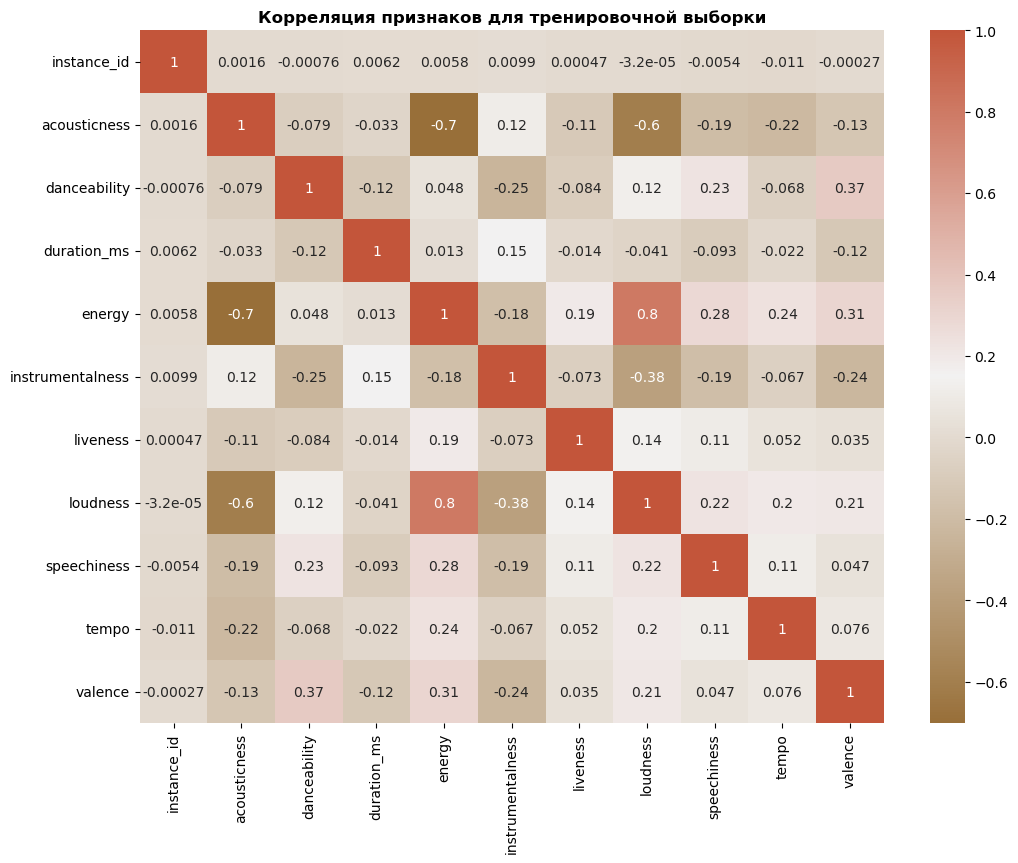

In [11]:
plt.figure(figsize=(12, 9))
plt.title('Корреляция признаков для тренировочной выборки', weight = 'bold')
cmap = sns.diverging_palette(50, 20, as_cmap=True)
sns.heatmap(t2.corr(method='spearman'), annot = True, cmap=cmap)
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    
-Теперь определённо видно, присутствует отрицательная корреляция между acousticness и energy (-0.7), а также между acousticness и loudness (-0.6) Более низкая корреляция присутствует между признаками instrumentalness и loudness (-0.38). Отрицательная корреляция говорит о том, что при увеличении одного признакак уменьшается другой признак. 

-Положительная коореляция (0.8) присутствует между признаками energy и loudness. Небольшая корреляция (0.37) присутствует между признаками danceability и valence.
</div>

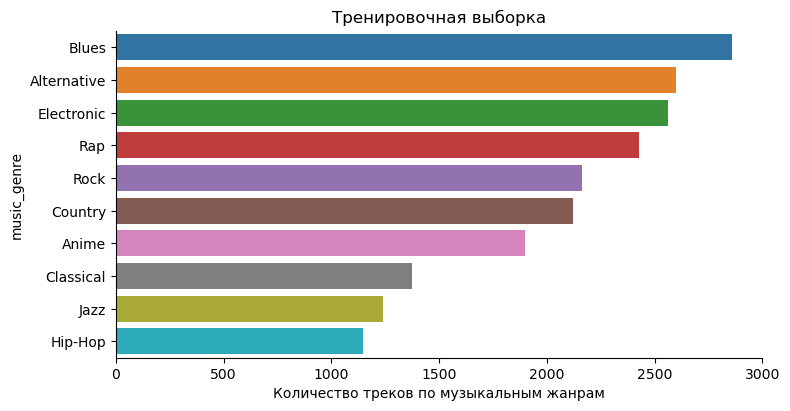

In [12]:
sns.catplot(data=df_train,
            y='music_genre', 
            kind='count', 
            height=4, 
            aspect=2, 
            order=df_train['music_genre'].value_counts
            (ascending=False).index).set(title='Тренировочная выборка')
plt.xlabel('Количество треков по музыкальным жанрам', color='black')
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    
Фаворита видно сразу, количество композиций в жанре "блюз" - больше всего. На втором месте располагается жанр "алтернатива". На несколько десятков позиций отстаёт жанр "Электроника". Тройку с конца (наименьшее количество композиций) открывает жанр "Хип-Хоп", за ним следует жанр "Джаз" И "Классическая".
</div>

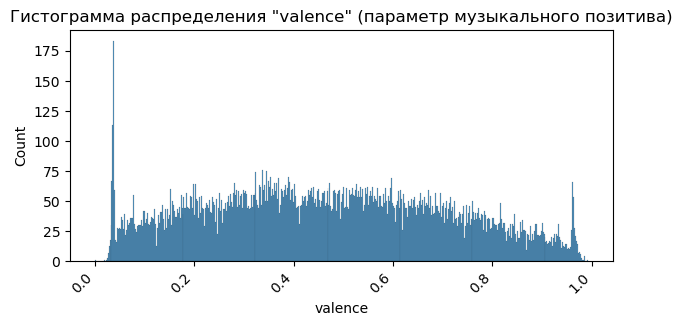

In [13]:
plt.subplots(1, figsize=(7, 3))
plt.title('Гистограмма распределения "valence" (параметр музыкального позитива)')
sns.histplot(data=df_train, x='valence', bins=500)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium',
)
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    Из гистограммы распределения "valence" (данный параметр отвечает за показатель музыкального позитива, чем он больше, тем композиция более позитивнее, радостнееЮ веселее) видно, что присутвтсвует почти 400 треков (суммарно) с депресивным, грустным или сердитым звучанием (показатель позитивно приближается к нулю), текстом. Также видно порядка 150 треков (суммарно), которыее вероятно всего смогут осчастливить даже самого опечаленного человека. Показатель позитивности приблежается к еденице.
</div>

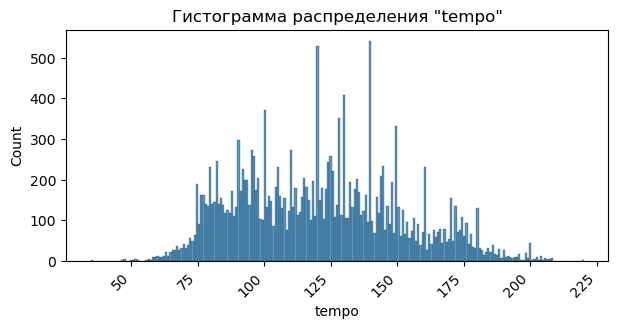

In [14]:
plt.subplots(1, figsize=(7, 3))
plt.title('Гистограмма распределения "tempo"')
sns.histplot(data=df_train, x='tempo', bins=225)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    Из гистограммы распределения "tempo" (темп трека удара в минутах), что фаворитами является треки со 120 bpm и 140bpm. В остальном треки имеют около-нормальное распределение.
</div>

In [15]:
Rap = df_train.loc[df_train['music_genre'] == 'Rap'] 
Rock = df_train.loc[df_train['music_genre'] == 'Rock']
Country = df_train.loc[df_train['music_genre'] == 'Country'] 
Alternative = df_train.loc[df_train['music_genre'] == 'Alternative'] 
Hip_Hop = df_train.loc[df_train['music_genre'] == 'Hip-Hop'] 
Blues = df_train.loc[df_train['music_genre'] == 'Blues'] 
Jazz = df_train.loc[df_train['music_genre'] == 'Jazz'] 
Electronic = df_train.loc[df_train['music_genre'] == 'Electronic'] 
Anime = df_train.loc[df_train['music_genre'] == 'Anime'] 
Classical = df_train.loc[df_train['music_genre'] == 'Classical'] 

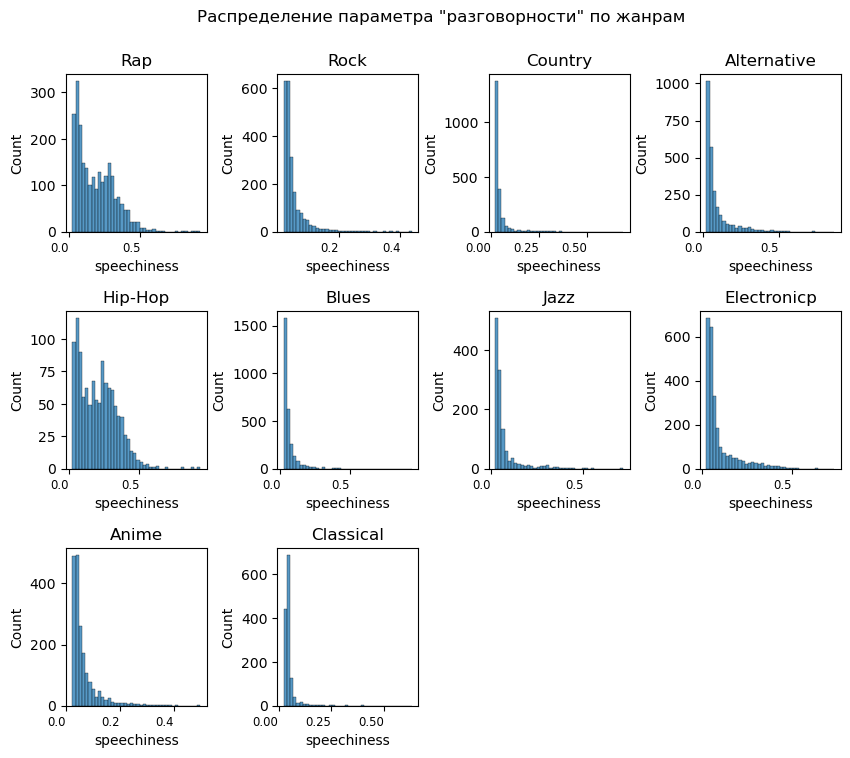

In [16]:
fig = plt.figure(figsize=(10, 8))
fig.tight_layout(h_pad=2)
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
fig.suptitle('Распределение параметра "разговорности" по жанрам')
plt.subplots_adjust(top=0.9)

ax1 = fig.add_subplot(3, 4, 1).set_title('Rap')    
sns.histplot(data=Rap, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)                    

ax2 = fig.add_subplot(3, 4, 2).set_title('Rock')    
sns.histplot(data=Rock, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax3 = fig.add_subplot(3, 4, 3).set_title('Country')    
sns.histplot(data=Country, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax4 = fig.add_subplot(3, 4, 4).set_title('Alternative')    
sns.histplot(data=Alternative, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax5 = fig.add_subplot(3, 4, 5).set_title('Hip-Hop')    
sns.histplot(data=Hip_Hop, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax6 = fig.add_subplot(3, 4, 6).set_title('Blues')    
sns.histplot(data=Blues, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax7 = fig.add_subplot(3, 4, 7).set_title('Jazz')    
sns.histplot(data=Jazz, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax8 = fig.add_subplot(3, 4, 8).set_title('Electronicp')    
sns.histplot(data=Electronic, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax9 = fig.add_subplot(3, 4, 9).set_title('Anime')    
sns.histplot(data=Anime, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax10 = fig.add_subplot(3, 4, 10).set_title('Classical')    
sns.histplot(data=Classical, x='speechiness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    Из гистограммы распределения "speechiness" (параметр "разговорности" трека), видно, что в диапазоне от 0.33 до 0.66 попадают категории только из жанров Репа и Хип-Хопа. В остальных жанрах данный параметр находится в категории ниже 0.33, что характеризует просто музыку и другие неречевые треки.
</div>

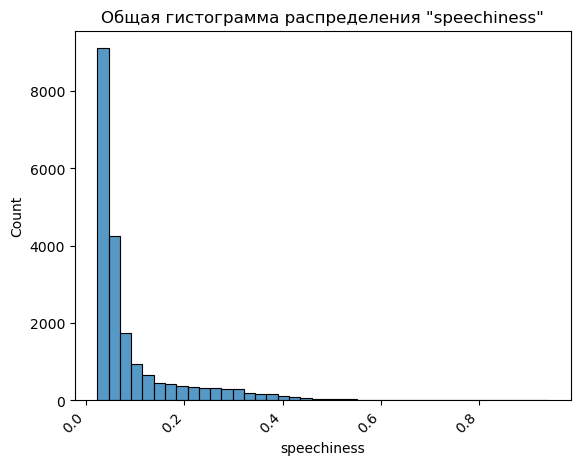

In [17]:
plt.title('Общая гистограмма распределения "speechiness"')
sns.histplot(data=df_train, x='speechiness', bins=40)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "speechiness" (параметр "разговорности" трека) подтверждается вверхнее заявленеие, болшинство треков относятся к неречевым и простому звучанию (около 15 тысяч композиций).
</div>

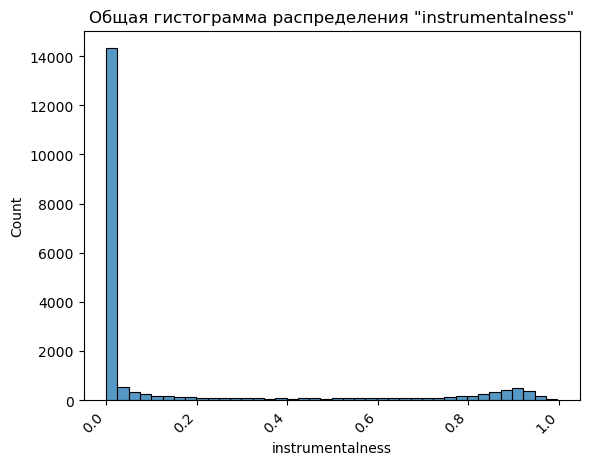

In [18]:
 plt.title('Общая гистограмма распределения "instrumentalness"')
sns.histplot(data=df_train, x='instrumentalness', bins=40)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

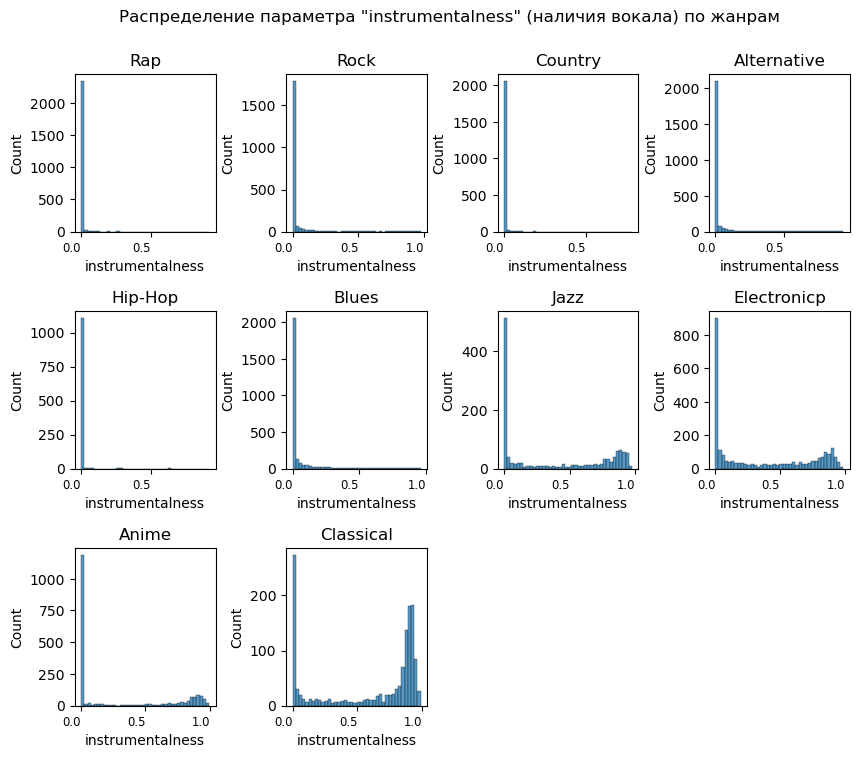

In [19]:
fig = plt.figure(figsize=(10, 8))
fig.tight_layout(h_pad=2)
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
fig.suptitle('Распределение параметра "instrumentalness" (наличия вокала) по жанрам')
plt.subplots_adjust(top=0.9)

ax1 = fig.add_subplot(3, 4, 1).set_title('Rap')    
sns.histplot(data=Rap, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)                    

ax2 = fig.add_subplot(3, 4, 2).set_title('Rock')    
sns.histplot(data=Rock, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax3 = fig.add_subplot(3, 4, 3).set_title('Country')    
sns.histplot(data=Country, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax4 = fig.add_subplot(3, 4, 4).set_title('Alternative')    
sns.histplot(data=Alternative, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax5 = fig.add_subplot(3, 4, 5).set_title('Hip-Hop')    
sns.histplot(data=Hip_Hop, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax6 = fig.add_subplot(3, 4, 6).set_title('Blues')    
sns.histplot(data=Blues, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax7 = fig.add_subplot(3, 4, 7).set_title('Jazz')    
sns.histplot(data=Jazz, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax8 = fig.add_subplot(3, 4, 8).set_title('Electronicp')    
sns.histplot(data=Electronic, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax9 = fig.add_subplot(3, 4, 9).set_title('Anime')    
sns.histplot(data=Anime, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax10 = fig.add_subplot(3, 4, 10).set_title('Classical')    
sns.histplot(data=Classical, x='instrumentalness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    Из гистограммы распределения "instrumentalness" (параметр наличия вокала), что данная гистограмма от части является противоположностью параметра speechiness. В speechiness если значение приближается к 1, то значит композиция имеет лаконичный текст, слова. В instrumentalness чем ближе значение к 1, тем больше вероятность, что композиция не имеет слов (вокала). 

Из вышепоказанных гистограмм видно, что вокал в большей степени отсутствует в классической музыке, затем можно выделить джаз и электронную. 
</div>

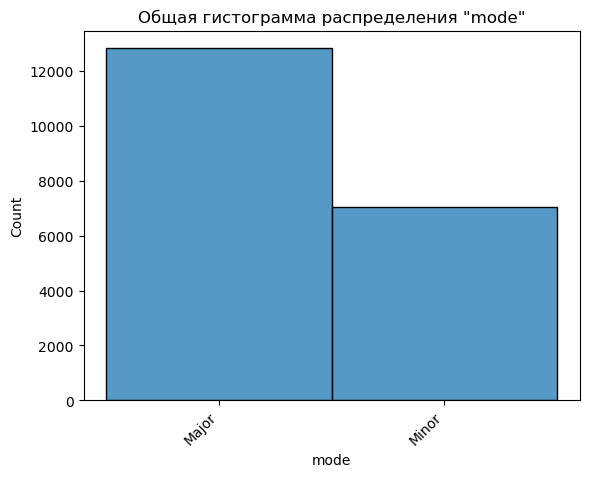

In [20]:
plt.title('Общая гистограмма распределения "mode"')
sns.histplot(data=df_train, x='mode', bins=2)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "mode" (параметр модальности композиции) видно, что число мажорных композиций практически в половину больше минорных композиций.
</div>

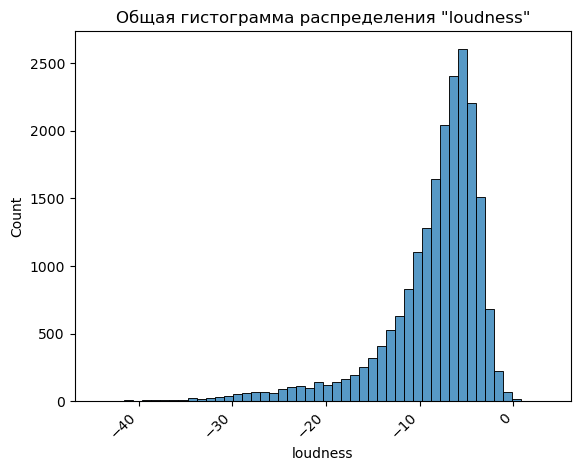

In [21]:
plt.title('Общая гистограмма распределения "loudness"')
sns.histplot(data=df_train, x='loudness', bins=50)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "loudness" (параметр громкости композиции) видно, что значительно число композиций звучат достаточно громко. Большая часть данных треков находится в диапазоне громкости от 0 до -10 Дб.
</div>

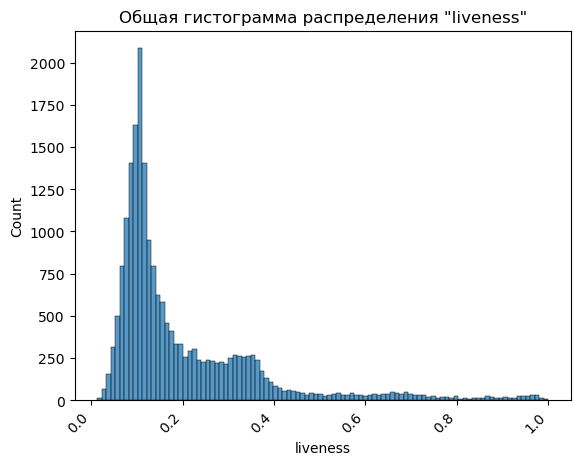

In [22]:
plt.title('Общая гистограмма распределения "liveness"')
sns.histplot(data=df_train, x='liveness', bins=100)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "liveness" (параметр позволяющий выделить исполняется ли композиция вживую, если значение приближается к 1) видно, что большая часть композиций сосредоточена между 0 и 0.2. Это говорит, что скорее всего это запись студийного трека или композиции. Т.е она играется с какого-то носителя. Число треков, которые превышают значение 0.8, что свидетельствует о большой вероятности исполнения трека вживую, очень мало, буквально можно посчитать вручную.
    
Мне стало интересно, какие жанры относятся к этому числу, исполнения вживую.
</div>

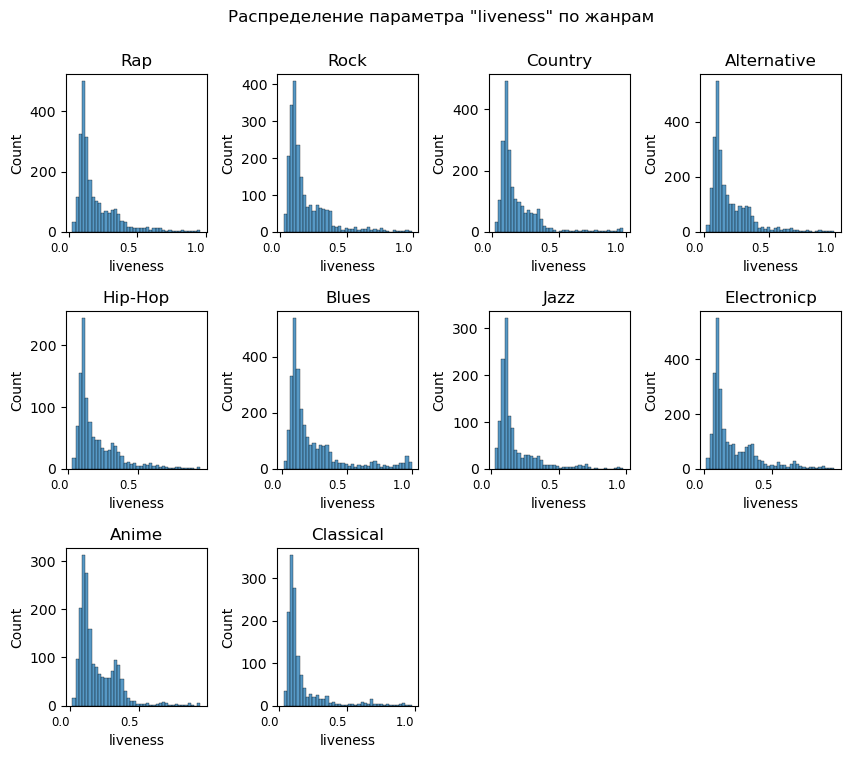

In [23]:
fig = plt.figure(figsize=(10, 8))
fig.tight_layout(h_pad=2)
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
fig.suptitle('Распределение параметра "liveness" по жанрам')
plt.subplots_adjust(top=0.9)

ax1 = fig.add_subplot(3, 4, 1).set_title('Rap')    
sns.histplot(data=Rap, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)                    

ax2 = fig.add_subplot(3, 4, 2).set_title('Rock')    
sns.histplot(data=Rock, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax3 = fig.add_subplot(3, 4, 3).set_title('Country')    
sns.histplot(data=Country, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax4 = fig.add_subplot(3, 4, 4).set_title('Alternative')    
sns.histplot(data=Alternative, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax5 = fig.add_subplot(3, 4, 5).set_title('Hip-Hop')    
sns.histplot(data=Hip_Hop, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax6 = fig.add_subplot(3, 4, 6).set_title('Blues')    
sns.histplot(data=Blues, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax7 = fig.add_subplot(3, 4, 7).set_title('Jazz')    
sns.histplot(data=Jazz, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax8 = fig.add_subplot(3, 4, 8).set_title('Electronicp')    
sns.histplot(data=Electronic, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax9 = fig.add_subplot(3, 4, 9).set_title('Anime')    
sns.histplot(data=Anime, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax10 = fig.add_subplot(3, 4, 10).set_title('Classical')    
sns.histplot(data=Classical, x='liveness', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    Из диаграмм видно, что Блюс в данном случае фаворит, данный жанр чаще всего исполнялся вживую. Присутствуют значения равные еденице.
</div>

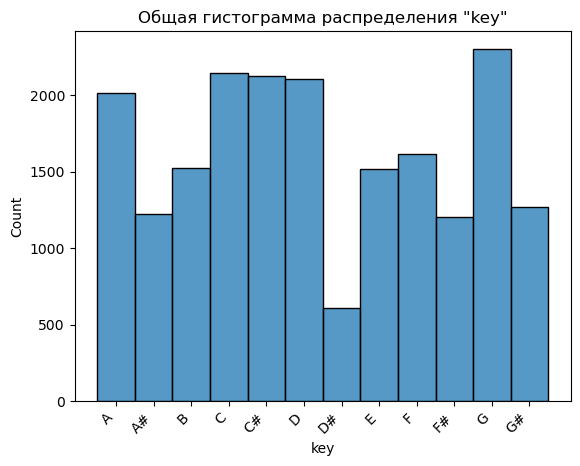

In [24]:
 plt.title('Общая гистограмма распределения "key"')
sns.histplot(data=df_train.sort_values(by='key', ascending=True), x='key', bins=12)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "key" (нота воспроизведения) видно, присутствуют различные ноты в композициях. Реже всего встречается D#. 
</div>

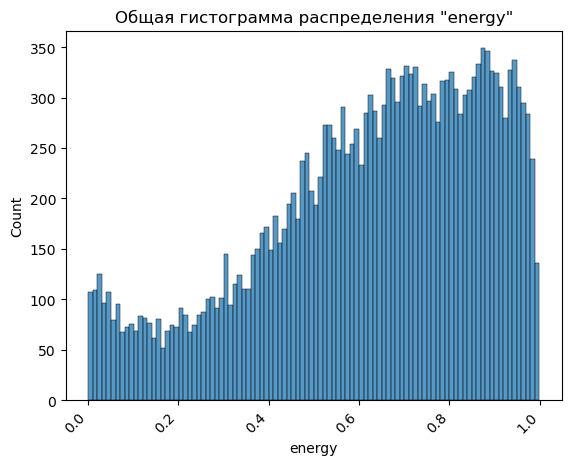

In [25]:
plt.title('Общая гистограмма распределения "energy"')
sns.histplot(data=df_train, x='energy', bins=100)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

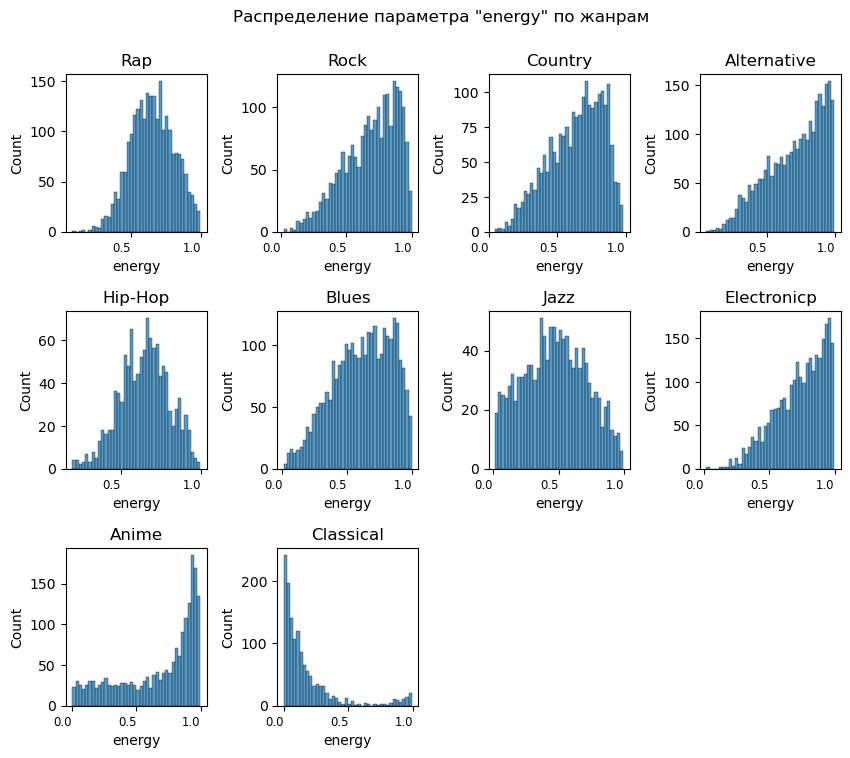

In [26]:
fig = plt.figure(figsize=(10, 8))
fig.tight_layout(h_pad=2)
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
fig.suptitle('Распределение параметра "energy" по жанрам')
plt.subplots_adjust(top=0.9)

ax1 = fig.add_subplot(3, 4, 1).set_title('Rap')    
sns.histplot(data=Rap, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)                    

ax2 = fig.add_subplot(3, 4, 2).set_title('Rock')    
sns.histplot(data=Rock, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax3 = fig.add_subplot(3, 4, 3).set_title('Country')    
sns.histplot(data=Country, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax4 = fig.add_subplot(3, 4, 4).set_title('Alternative')    
sns.histplot(data=Alternative, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax5 = fig.add_subplot(3, 4, 5).set_title('Hip-Hop')    
sns.histplot(data=Hip_Hop, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax6 = fig.add_subplot(3, 4, 6).set_title('Blues')    
sns.histplot(data=Blues, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax7 = fig.add_subplot(3, 4, 7).set_title('Jazz')    
sns.histplot(data=Jazz, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax8 = fig.add_subplot(3, 4, 8).set_title('Electronicp')    
sns.histplot(data=Electronic, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax9 = fig.add_subplot(3, 4, 9).set_title('Anime')    
sns.histplot(data=Anime, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax10 = fig.add_subplot(3, 4, 10).set_title('Classical')    
sns.histplot(data=Classical, x='energy', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

plt.show()

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "energy" (энергичность композиции) видно, что количество энергичных, качовых треков в общей выборке значительно больше, чем спокойные треки. На раздельных гистограммах по жанрам показывается, что наименее энергичные композиции относятся к классике. На удивление, жанр хип-хоп менее энергичный чем жанр блюз.
</div>

In [27]:
#report_test

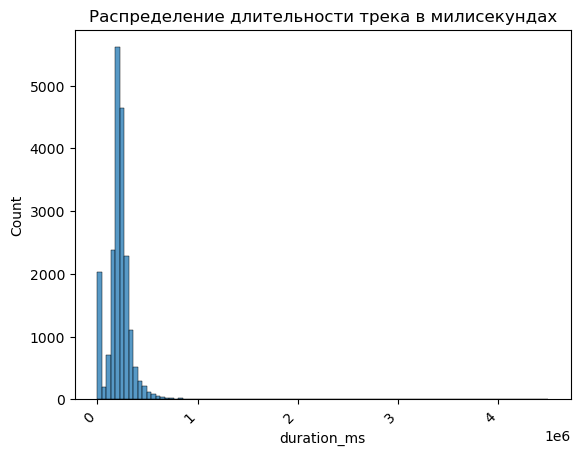

In [28]:
plt.title('Распределение длительности трека в милисекундах')
sns.histplot(data=df_train, x='duration_ms', bins=100)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

In [29]:
df_train['duration_ms'].mean().round()

220375.0

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "duration_ms" (длительность трека в мс) видно, что среднее значение примерно составляет 220 тысяч мс., а это примерно 3.5 минуты.
</div>

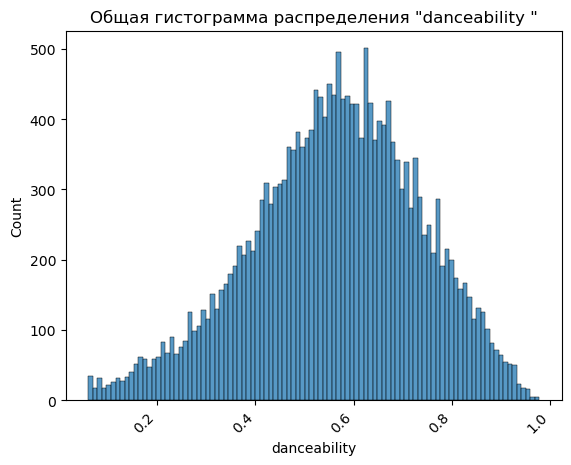

In [30]:
plt.title('Общая гистограмма распределения "danceability "')
sns.histplot(data=df_train, x='danceability', bins=100)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

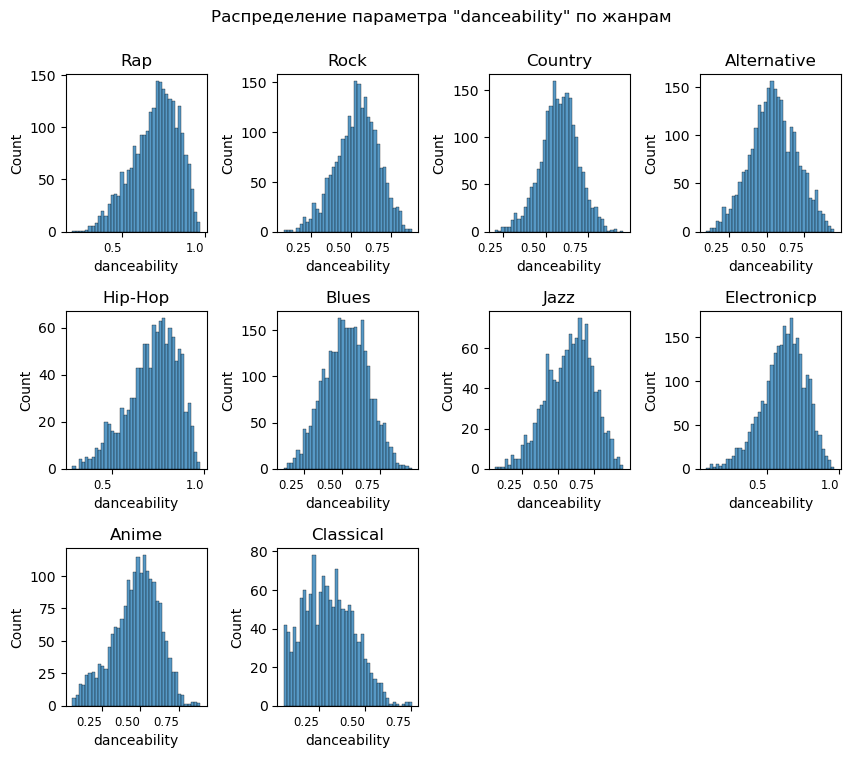

In [31]:
fig = plt.figure(figsize=(10, 8))
fig.tight_layout(h_pad=2)
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
fig.suptitle('Распределение параметра "danceability" по жанрам')
plt.subplots_adjust(top=0.9)

ax1 = fig.add_subplot(3, 4, 1).set_title('Rap')    
sns.histplot(data=Rap, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)                    

ax2 = fig.add_subplot(3, 4, 2).set_title('Rock')    
sns.histplot(data=Rock, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax3 = fig.add_subplot(3, 4, 3).set_title('Country')    
sns.histplot(data=Country, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax4 = fig.add_subplot(3, 4, 4).set_title('Alternative')    
sns.histplot(data=Alternative, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax5 = fig.add_subplot(3, 4, 5).set_title('Hip-Hop')    
sns.histplot(data=Hip_Hop, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax6 = fig.add_subplot(3, 4, 6).set_title('Blues')    
sns.histplot(data=Blues, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax7 = fig.add_subplot(3, 4, 7).set_title('Jazz')    
sns.histplot(data=Jazz, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax8 = fig.add_subplot(3, 4, 8).set_title('Electronicp')    
sns.histplot(data=Electronic, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax9 = fig.add_subplot(3, 4, 9).set_title('Anime')    
sns.histplot(data=Anime, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

ax10 = fig.add_subplot(3, 4, 10).set_title('Classical')    
sns.histplot(data=Classical, x='danceability', bins=40)
plt.xticks(
    rotation=0,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='small'
)

plt.show()

In [32]:
df_train['danceability'].mean().round(3)

0.562

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "danceability" (параметр отвечающий за танцевальность трека) видно, что среднее значение 0.562. В общем и целорм все треки могут подходить для танцев - реп, хип-хоп и джаз особенно, их распределение смещено ближе к 1.
</div>

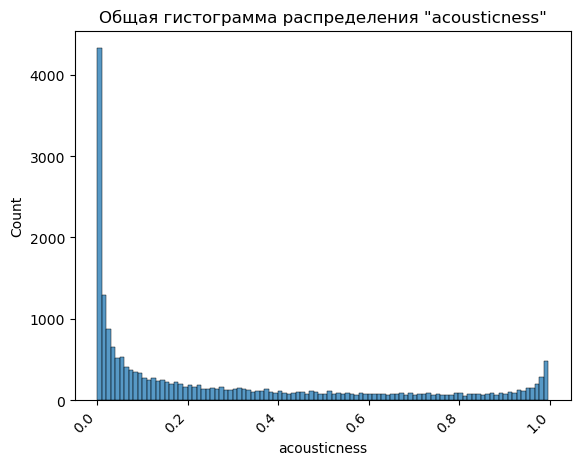

In [33]:
plt.title('Общая гистограмма распределения "acousticness"')
sns.histplot(data=df_train, x='acousticness', bins=100)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium'
)
plt.show()

In [34]:
df_train['acousticness'].mean().round(3)

0.275

<div class="alert alert-block alert-info">
<b></b> 
    По общей гистограмме распределения "acousticness" (параметр показывающий акустичность трека) видно, что большинство треков неаккустичны. Несколько тысяч композиций находится на близкой 0 показателю.
</div>

## 1.3. Предобработка данных

<div class="alert alert-block alert-info">
<b></b> 
Проверим, присутствуют ли дубликаты в нашем датафрейме.
    
Видно, что дубликаты отсутствуют, перейдёт к работе с пропусками.
</div>

In [35]:
df_train.duplicated().sum()

0

<div class="alert alert-block alert-info">
<b></b> 
    Взглянем на датафрейм, возьмём от туда случайные строки.
</div>

In [36]:
df_train.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
11009,63214.0,One Thing - Grant Remix,0.0747,0.469,170551.0,0.793,0.000014,C#,0.216,-4.413,Minor,0.0857,76.041,4-Apr,0.426,Electronic
3225,68562.0,Little Journey,0.2360,0.315,95853.0,0.781,0.185000,NaN,0.504,-10.258,Minor,0.2010,117.610,4-Apr,0.558,Electronic
19001,72219.0,Fire Away,0.0550,0.559,244333.0,0.301,0.009790,A,0.101,-9.066,Major,0.0297,116.123,3-Apr,0.177,Country
17466,21813.0,Boston,0.1820,0.404,245933.0,0.571,0.000021,C,0.129,-5.069,Major,0.0303,147.010,4-Apr,0.290,Rock
16396,61625.0,What The Cowgirls Do,0.3760,0.652,183507.0,0.859,0.000083,G,0.317,-8.839,Minor,0.0341,152.885,4-Apr,0.967,Country


In [37]:
df_train['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

<div class="alert alert-block alert-info">
<b></b> 
    Есть вопросы к столбцу с датой загрузки, взгялнем на него и увидим, что присутствует лишь 4 дня для когда загружались треки. Думаю данная информация не потребуется в дальнейшем для обучения модели, поэтому принимаю решение удалить столбец.
    
Также можно удалить столбец с названием треков и их уникальным id. Он тоже нам не понадобится.
</div>

In [38]:
df_train.drop('obtained_date', axis= 1 , inplace=True)

In [39]:
df_train.drop('track_name', axis= 1 , inplace=True)

<div class="alert alert-block alert-info">
<b></b> 
    Метод ProfileReport позволил нам увидеть пропуски в трёх столбцах. Рассмотрим их чуть подробнее, природу пропусков.
    
-key has 735 (3.6%) missing values
    
-mode has 506 (2.5%) missing values
    
-tempo has 442 (2.2%) missing values
</div>

<div>
<b>Количество пропусков по жанрам относительно столбца 'key':</b> 

</div>

In [40]:
df_train[df_train['key'].isnull()].sample(6)

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
6958,75457.0,0.061700,0.433,202333.0,0.459,0.937000,NaN,0.1110,-14.350,Minor,0.0497,169.935,0.426,Anime
3026,91291.0,0.842000,0.493,219960.0,0.159,0.581000,NaN,0.1620,-11.048,Major,0.0434,116.074,0.380,Alternative
1122,65266.0,0.026400,0.744,194520.0,0.770,0.000013,NaN,0.1330,-4.071,Minor,0.0531,128.005,0.901,Rock
14215,68238.0,0.000219,0.459,326107.0,0.979,0.000016,NaN,0.1060,-4.042,Minor,0.0855,150.003,0.402,Alternative
3578,53591.0,0.188000,0.766,261176.0,0.526,0.000000,NaN,0.0744,-6.228,Minor,0.2330,136.105,0.568,Hip-Hop
7919,78158.0,0.119000,0.723,177799.0,0.929,0.000000,NaN,0.1710,-3.022,Minor,0.1060,92.964,0.812,Hip-Hop


In [41]:
df_train[df_train['key'].isnull()].groupby('music_genre').agg('count')['instance_id']

music_genre
Alternative     90
Anime           67
Blues          104
Classical       40
Country         76
Electronic      91
Hip-Hop         46
Jazz            42
Rap            100
Rock            79
Name: instance_id, dtype: int64

<div>
<b>Количество пропусков по жанрам относительно столбца 'mode':</b> 

</div>

In [42]:
df_train[df_train['mode'].isnull()].sample(6)

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
15982,87817.0,0.642000,0.439,101813.0,0.0817,0.375000,G,0.0775,-33.351,NaN,0.0367,157.886,0.840,Classical
3009,52239.0,0.964000,0.363,44947.0,0.1060,0.950000,A#,0.1430,-15.935,NaN,0.0476,72.038,0.196,Anime
5543,55885.0,0.000131,0.461,258293.0,0.9850,0.000006,D,0.1020,-3.439,NaN,0.1220,161.968,0.529,Anime
10673,20403.0,0.232000,0.693,219190.0,0.6560,0.000000,C,0.0602,-4.254,NaN,0.0305,98.936,0.502,Alternative
8174,34492.0,0.014100,0.171,259373.0,0.7530,0.048100,C,0.1100,-4.871,NaN,0.0312,77.760,0.284,Alternative
17630,59836.0,0.139000,0.800,186253.0,0.6720,0.000000,C#,0.3030,-4.939,NaN,0.1650,145.985,0.324,Hip-Hop


In [43]:
df_train[df_train['mode'].isnull()].groupby('music_genre').agg('count')['instance_id']

music_genre
Alternative    66
Anime          51
Blues          68
Classical      34
Country        53
Electronic     64
Hip-Hop        17
Jazz           23
Rap            70
Rock           60
Name: instance_id, dtype: int64

<div>
<b>Количество пропусков по жанрам относительно столбца 'tempo':</b> 

</div>

In [44]:
df_train[df_train['tempo'].isnull()].sample(6)

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
8330,59243.0,0.91500,0.538,312787.0,0.275,0.000000,C#,0.1340,-10.310,Major,0.0282,NaN,0.301,Anime
8022,71898.0,0.02160,0.632,247227.0,0.767,0.000000,A,0.3780,-4.002,Minor,0.2320,NaN,0.622,Rap
4978,25089.0,0.00739,0.385,251107.0,0.740,0.000000,C#,0.0868,-4.135,Major,0.0463,NaN,0.312,Rock
9087,24858.0,0.02740,0.585,176621.0,0.722,0.000000,G#,0.1110,-6.044,Major,0.0515,NaN,0.742,Country
17004,28969.0,0.00834,0.741,211920.0,0.752,0.001650,D,0.0438,-4.968,Major,0.0386,NaN,0.609,Rock
12538,61406.0,0.03430,0.627,199573.0,0.823,0.000008,F#,0.1190,-4.684,Minor,0.0289,NaN,0.538,Country


In [45]:
df_train[df_train['tempo'].isnull()].groupby('music_genre').agg('count')['instance_id']

music_genre
Alternative    58
Anime          38
Blues          62
Classical      33
Country        51
Electronic     49
Hip-Hop        29
Jazz           17
Rap            51
Rock           54
Name: instance_id, dtype: int64

<div class="alert alert-block alert-info">
<b></b> 
    Глядя на данные пропуски, можно предположить, что скорее всего они не были заполнены или из-за человеческого фактора, не указали, когда выкладывали трек в приложение. Хотя странно звучит, что при загрузке трека на платформу нужно указывать модально, сколько BPM у композиции и ноту воспроизведения. Вероятнее всего система не смогла определить корректно и оставила пропуск. Раз система не смогла сделать это, попробуем это выполнить за неё. Пока просто не сильно понятно, как повлияют при обучении потеря этих признаков если мы их удалим. В дальнейшем рассмотрим вариант, если мы просто удалим данные пропуски.
    
Заполним пропуски используя метод ближайших соседей KNNinputer.
</div>

<div class="alert alert-block alert-info">
<b></b> 
    Дополнительно подготовим датафрейм к дальнейшему обучению.
</div>

In [46]:
state = 12345

In [47]:
df_train.drop('instance_id', axis= 1 , inplace=True)

In [48]:
df_test.drop(['instance_id', 'obtained_date', 'track_name'], axis= 1 , inplace=True)

<div class="alert alert-block alert-info">
<b></b> 
    Разбиваем тренировочную выборку.
</div>

In [49]:
# создадим признаки для моделей
features_train = df_train.drop('music_genre', axis=1)

# выделим целевой признак
target_train = df_train['music_genre']

In [50]:
x_train, x_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.2, random_state=state)
x_train.shape, x_test.shape

((16315, 12), (4079, 12))

In [51]:
# зададим диапазоны гиперпараметров для подбора
param_distributions = {'RFC__n_estimators': range(50, 325, 25),
                       'RFC__max_depth': range(1, 18, 2),
                       'RFC__min_samples_split': range(2, 52, 5),
                       'RFC__min_samples_leaf': range(2, 52, 5)}

# подготовим кросс-валидацию на 3-х выборках
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=state)

<div class="alert alert-block alert-info">
<b></b> 
    Применяем порядковое кодирование через Pipe-line.
</div>

In [52]:
s_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
pipe_cat = Pipeline([('imputer', s_imputer), ('encoder', ohe_encoder)])

res_cat_Xtrain = pipe_cat.fit_transform(x_train[['key', 'mode']])
res_cat_Xtest = pipe_cat.transform(x_test[['key', 'mode']])
cat_df_test = pipe_cat.transform(df_test[['key', 'mode']])


cat_df_Xtrain = pd.DataFrame(res_cat_Xtrain, columns=pipe_cat.get_feature_names_out())
cat_df_Xtest = pd.DataFrame(res_cat_Xtest, columns=pipe_cat.get_feature_names_out())
for_cat_df_test = pd.DataFrame(cat_df_test, columns=pipe_cat.get_feature_names_out())

In [53]:
cat_df_Xtest

,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_unknown,mode_Minor,mode_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4074,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4076,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4077,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-block alert-info">
<b></b> 
    Масштабируем данные через Pipe-line.
</div>

In [54]:
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
std_scaler = StandardScaler()
pipe_num = Pipeline([('knn_imputer', knn_imputer), ('scaler', std_scaler)])

res_num_Xtrain = pipe_num.fit_transform(x_train.drop(['key', 'mode'], axis=1))
res_num_Xtest = pipe_num.transform(x_train.drop(['key', 'mode'], axis=1))
num_df_test = pipe_num.transform(df_test.drop(['key', 'mode'], axis=1))

res_num_Xtrain = pd.DataFrame(res_num_Xtrain, columns=pipe_num.get_feature_names_out())
res_num_Xtest = pd.DataFrame(res_num_Xtest, columns=pipe_num.get_feature_names_out())
res_num_df_test = pd.DataFrame(num_df_test, columns=pipe_num.get_feature_names_out())

In [55]:
col_transformer = ColumnTransformer([('pipe_num', pipe_num, [x for x in features_train.columns if features_train[x].dtype!='object']),
                                     ('pipe_cat', pipe_cat, [x for x in features_train.columns if features_train[x].dtype=='object'])])

In [56]:
resXtr = col_transformer.fit_transform(x_train)
resXtes = col_transformer.transform(x_test)
redDftest = col_transformer.transform(df_test)

In [57]:
X_train = pd.DataFrame(resXtr, columns = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()])
X_test = pd.DataFrame(resXtes, columns = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()])
df_test_new = pd.DataFrame(redDftest, columns = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()])

<div class="alert alert-block alert-info">
<b>модель BaggingClassifier с заполнением пропусков</b> 
    
</div>

In [112]:
model_BGC = BaggingClassifier(estimator=SVC(),n_estimators=10, random_state=state)
pipeline_BGC = make_pipeline(model_BGC)
pipeline_BGC

Pipeline(steps=[('baggingclassifier',
                 BaggingClassifier(estimator=SVC(), random_state=12345))])

In [59]:
pipeline_BGC.fit(X_train, y_train)

Pipeline(steps=[('baggingclassifier',
                 BaggingClassifier(estimator=SVC(), random_state=12345))])

In [60]:
preds_BGC = pipeline_BGC.predict(X_test)

In [61]:
f1_score(y_test, preds_BGC, average='micro').round(4)

0.4641

In [62]:
preds_KAGL = pipeline_BGC.predict(df_test_new)

In [63]:
preds_KAGL

array(['Rap', 'Alternative', 'Rap', ..., 'Rap', 'Anime', 'Blues'],
      dtype=object)

In [64]:
df_KAGL = pd.DataFrame(data=preds_KAGL)

In [65]:
df_test_copy.insert(loc = 2, # это будет второй по счету столбец
                 column = 'music_genre', # название столбца
                 value = df_KAGL)

In [66]:
final_df_kagl = df_test_copy[['instance_id', 'music_genre']]

In [67]:
final_df_kagl.to_csv (r'C:/Users/79333/Desktop/music-project/final_df_kagl.csv', index= False)

<div class="alert alert-block alert-info">
<b>модель HistGradientBoostingClassifier без заполнения пропусков</b> 
    
</div>

In [68]:
cat_columns = features_train.select_dtypes(include='object').columns.tolist()
num_columns = features_train.select_dtypes(include='number').columns.tolist()
cat_columns, num_columns

(['key', 'mode'],
 ['acousticness',
  'danceability',
  'duration_ms',
  'energy',
  'instrumentalness',
  'liveness',
  'loudness',
  'speechiness',
  'tempo',
  'valence'])

In [69]:
column_transformer = make_column_transformer((StandardScaler(), num_columns),
                                             (OneHotEncoder(drop='first'), cat_columns),
                                              remainder='passthrough')  

In [70]:
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['acousticness', 'danceability', 'duration_ms',
                                  'energy', 'instrumentalness', 'liveness',
                                  'loudness', 'speechiness', 'tempo',
                                  'valence']),
                                ('onehotencoder', OneHotEncoder(drop='first'),
                                 ['key', 'mode'])])

In [144]:
model_HGBC = HistGradientBoostingClassifier(random_state=state, class_weight='balanced', max_iter=180, max_depth=4)

In [145]:
pipeline = make_pipeline(column_transformer, model_HGBC)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['key', 'mode'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_depth=4, max_iter=180,
                                                random_state=12345))])

In [146]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['key', 'mode'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_depth=4, max_iter=180,
                                                random_state=12345))])

In [147]:
preds = pipeline.predict(x_test)

In [148]:
f1_score(y_test, preds, average='micro').round(4)

0.4614

In [76]:
preds_f = pipeline.predict(df_test)

In [77]:
df_HGBC = pd.DataFrame(data=preds_f)

In [78]:
final_df_kagl_1 = df_test_copy1.copy()

In [79]:
final_df_kagl_1.insert(loc = 2, # это будет второй по счету столбец
                 column = 'music_genre', # название столбца
                 value = df_HGBC)

In [80]:
final_df_kagl_1 = final_df_kagl_1[['instance_id', 'music_genre']]

In [81]:
final_df_kagl_1.to_csv (r'C:/Users/79333/Desktop/music-project/final_df_kagl_1.csv', index= False)

<div class="alert alert-block alert-info">
<b>модель HistGradientBoostingClassifier c заполнением пропусков</b> 
    
</div>

In [115]:
hyperparameter_space_HGBC = {'max_depth':[2,3,4,6,8,10,12,15,20],
                        'max_iter':[100, 120, 140, 160, 180, 200]
                       }


rs_HGBC = RandomizedSearchCV(model_HGBC, param_distributions=hyperparameter_space_HGBC,
                        n_iter=10, scoring="f1", random_state=state,
                        n_jobs=-1, cv=10, return_train_score=True)

rs_HGBC.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                            random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 6, 8, 10, 12, 15,
                                                      20],
                                        'max_iter': [100, 120, 140, 160, 180,
                                                     200]},
                   random_state=12345, return_train_score=True, scoring='f1')

In [150]:
print("Optimal hyperparameter combination:", rs_HGBC.best_params_)
print()
print("Mean cross-validated training accuracy score:",
      rs_HGBC.best_score_)
rs_HGBC.best_estimator_.fit(X_train, y_train)
y_pred = rs_HGBC.best_estimator_.predict(X_test)

Optimal hyperparameter combination: {'max_iter': 180, 'max_depth': 8}

Mean cross-validated training accuracy score: nan


In [123]:
f1_score(y_test, y_pred, average='micro').round(4)

0.4484

<div class="alert alert-block alert-info">
<b>модель RandomForestClassifier c заполнением пропусков</b>
    
Заполнение пропусков выполнено выше.
    
</div>

In [151]:
model_RFC = RandomForestClassifier(max_depth=12, n_estimators=160, random_state=state)
pipeliyne_RFC = make_pipeline(model_RFC)
pipeline_RFC

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, n_estimators=160,
                                        random_state=12345))])

In [152]:
pipeline_RFC.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, n_estimators=160,
                                        random_state=12345))])

In [153]:
preds_RFC = pipeline_RFC.predict(X_test)

In [154]:
f1_score(y_test, preds_RFC, average='micro').round(5)

0.481

In [155]:
preds_RFC = pipeline_RFC.predict(df_test_new)

In [156]:
df_RFC = pd.DataFrame(data=preds_RFC)

In [157]:
final_df_kagl_2 = df_test_copy1.copy()

In [158]:
final_df_kagl_2.insert(loc = 2, # это будет второй по счету столбец
                 column = 'music_genre', # название столбца
                 value = df_RFC)

In [159]:
final_df_kagl_2 = final_df_kagl_2[['instance_id', 'music_genre']]

In [160]:
final_df_kagl_2.to_csv (r'C:/Users/79333/Desktop/music-project/final_df_kagl_2.csv', index= False)

In [92]:
hyperparameter_space = {'max_depth':[2,3,4,6,8,10,12,15,20],
                        'n_estimators':[100, 120, 140, 160, 180]
                       }


rs = RandomizedSearchCV(model_RFC, param_distributions=hyperparameter_space,
                        n_iter=10, scoring="f1", random_state=state,
                        n_jobs=-1, cv=10, return_train_score=True)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(max_depth=12,
                                                    n_estimators=160,
                                                    random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 6, 8, 10, 12, 15,
                                                      20],
                                        'n_estimators': [100, 120, 140, 160,
                                                         180]},
                   random_state=12345, return_train_score=True, scoring='f1')

In [93]:
print("Optimal hyperparameter combination:", rs.best_params_)
print()
print("Mean cross-validated training accuracy score:",
      rs.best_score_)
rs.best_estimator_.fit(X_train, y_train)
y_pred = rs.best_estimator_.predict(X_test)

Optimal hyperparameter combination: {'n_estimators': 160, 'max_depth': 12}

Mean cross-validated training accuracy score: nan


<div class="alert alert-block alert-info">
<b>Выводы</b> 
 
1) Выполнен анализ данных всех столбцов тренировочной выборки. Заключения по ним сделаны выше. Каких-то сильно выбивающихся аномалий замечено мною не было. Использовал метод ProfileReport, чтобы оперативно ознакомиться с данными. ProfileReport применён как к тренировочному датафрейму, так и к тестовому.
    
2) Выполнена предобработка данных: удалены некоторые столбцы, которые не повлияют на обучения моделей (instance_id, obtained_date, track_name). В целом можно былоб попробовать удалить столбцы key и mode. Коллеги в чатах говорили, что на обучении это практически никак не отразится, из-за того что минорность мажорность, аккорды, присутствуют в каждой песне и это только усложнит модель и время её обучения. Данное предположение уже будет проверенно мною позже.
    
3) Рассмотрено было три модели: RandomForestClassifier, HistGradientBoostingClassifier, BaggingClassifier. Данные модели были выбраны в связи с тем, что модели HistGradientBoostingClassifier, BaggingClassifier хорошо отрабатывают с пропущенными значениями, так как в работе я рассматривал варианты с заполнением пропусков, так и без. 

4) Лучшую метрку F1 показала модель случайного леса  F1=0.481 со следующими гиппер-параметрами: глубина - 12, максимальное разветвление 160.
5) Остальные модели также показали неплохие результаты. Модель BaggingClassifier показала значение F1-меры = 0.4641 (с заполнением пропусков), а модель HistGradientBoostingClassifier показала значением F1-меры = 0.4614 (без заполнения пропусков).

6) В данной работе также выполнин первые попытки использования pipeline-ов и поиска подбора гиппер параметров через RandomizedSearchCV. Заложил уменяю и в будущем буду усложнять данные способы, чтобы более точно изучить их.
    
7) На общих созвонах слушал коллег и о их подходах к повышению точности модели. Позже подробнее ознакомлюсь с созданием синтеических, полиномиальных признаков и как они отразятся на повышении точности модели.
    
</div>